# Time Series Analytics: Part 2 - Decomposition

---
### Contents:

1. Problem Statement


2. Imports


3. Load Dataset


---

# 1. Background

There are primarily **three** types of time-series patterns: 

- Trend: A trend is a long-term pattern that shows the general direction in which the data is moving over time. A trend can be linear or nonlinear, and it can change over time.


- Seasonality: Seasonality refers to a pattern that repeats itself at regular intervals over time, typically within a year or less. 


- Cycles: Cycles refer to a pattern that repeats itself over a period of time that is longer than a year, such as every 5 or 10 years.


When we decompose a time series into components, we usually combine the trend and cycle into a single trend-cycle component (sometimes called the trend for simplicity). Thus we think of a time series as comprising three components: a trend-cycle component, a seasonal component, and a remainder component (containing anything else in the time series).

In this project, we consider some **common methods for extracting these components** from a time series.

### Components
For time series data:-

Additive Decompostion: $y_t = S_t + T_t + R_t$


Additive Decompostion: $y_t = S_t \times T_t \times R_t$


Logarthmic Decompostion: $\log y_t = \log S_t + \log T_t + \log R_t$


where $y_t$ is the time series data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component, and $R_t$ is the remainder component, all at period time $t$.


# 2. Imports

In [2]:
library(stats)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(corrplot)
library(broom)
library(ggpubr)
library(MASS)
library(writexl)
library(readxl)
library(ggplot2)
library(ggspectra)
library(ggrepel)
library(forecast)
library(fpp3)
library(lubridate)

# 3. Loading Dataset

In [3]:
# CSV
# df = read.csv("data/Preprocessed_Dataset.csv", sep = ",")
# EXCEL
df = read_excel("data/Preprocessed_Dataset.xlsx")
df$Date <- as.Date(df$Date, format = "%Y-%m-%d")
str(df)

tibble [6,435 × 16] (S3: tbl_df/tbl/data.frame)
 $ Store       : num [1:6435] 1 1 1 1 1 1 1 1 1 1 ...
 $ Date        : Date[1:6435], format: "2010-02-05" "2010-02-12" ...
 $ Temperature : num [1:6435] 42.3 38.5 39.9 46.6 46.5 ...
 $ Fuel_Price  : num [1:6435] 2.57 2.55 2.51 2.56 2.62 ...
 $ MarkDown1   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown2   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown3   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown4   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown5   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ CPI         : num [1:6435] 211 211 211 211 211 ...
 $ Unemployment: num [1:6435] 8.11 8.11 8.11 8.11 8.11 ...
 $ IsHoliday   : logi [1:6435] FALSE TRUE FALSE FALSE FALSE FALSE ...
 $ Weekly_Sales: num [1:6435] 1643691 1641957 1611968 1409728 1554807 ...
 $ Type        : chr [1:6435] "A" "A" "A" "A" ...
 $ Size        : num [1:6435] 151315 151315 151315 151315 151315 ...
 $ Holiday_Flag

In [4]:
dim(df)

[1] 6435   16

# 4. Time Series Decomposition

Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category.

- 4.1. **Classical decomposition**
- 4.2. X11 decomposition
- 4.3. SEATS decomposition
- 4.4. Seasonal and Trend decomposition using Loess
- 4.5. **Classical vs STL decomposition**
- 4.6. **Forecasting with decomposition**

In [5]:
org_data = data.frame(Store=df$Store, 
                      Date=df$Date, 
                      Temperature=df$Temperature, 
                      CPI=df$CPI,
                      Weekly_Sales=df$Weekly_Sales)
head(org_data, 5)

# Average Sales per week across all store locations:
avg_data = org_data %>%
            group_by(Date) %>%
            summarise(Sales = sum(Weekly_Sales)) %>%
            ungroup()
head(avg_data, 5)

# Convert data into time series, across all store locations:
df_ts = avg_data %>%
        mutate(Date = yearweek(Date)) %>%
        as_tsibble(index = Date)
head(df_ts, 5)

,Store,Date,Temperature,CPI,Weekly_Sales
,<dbl>,<date>,<dbl>,<dbl>,<dbl>
1,1,2010-02-05,42.31,211.0964,1643691
2,1,2010-02-12,38.51,211.2422,1641957
3,1,2010-02-19,39.93,211.2891,1611968
4,1,2010-02-26,46.63,211.3196,1409728
5,1,2010-03-05,46.50,211.3501,1554807


Date,Sales
<date>,<dbl>
2010-02-05,49750740
2010-02-12,48336678
2010-02-19,48276994
2010-02-26,43968571
2010-03-05,46871470


Date,Sales
<week>,<dbl>
2010 W05,49750740
2010 W06,48336678
2010 W07,48276994
2010 W08,43968571
2010 W09,46871470


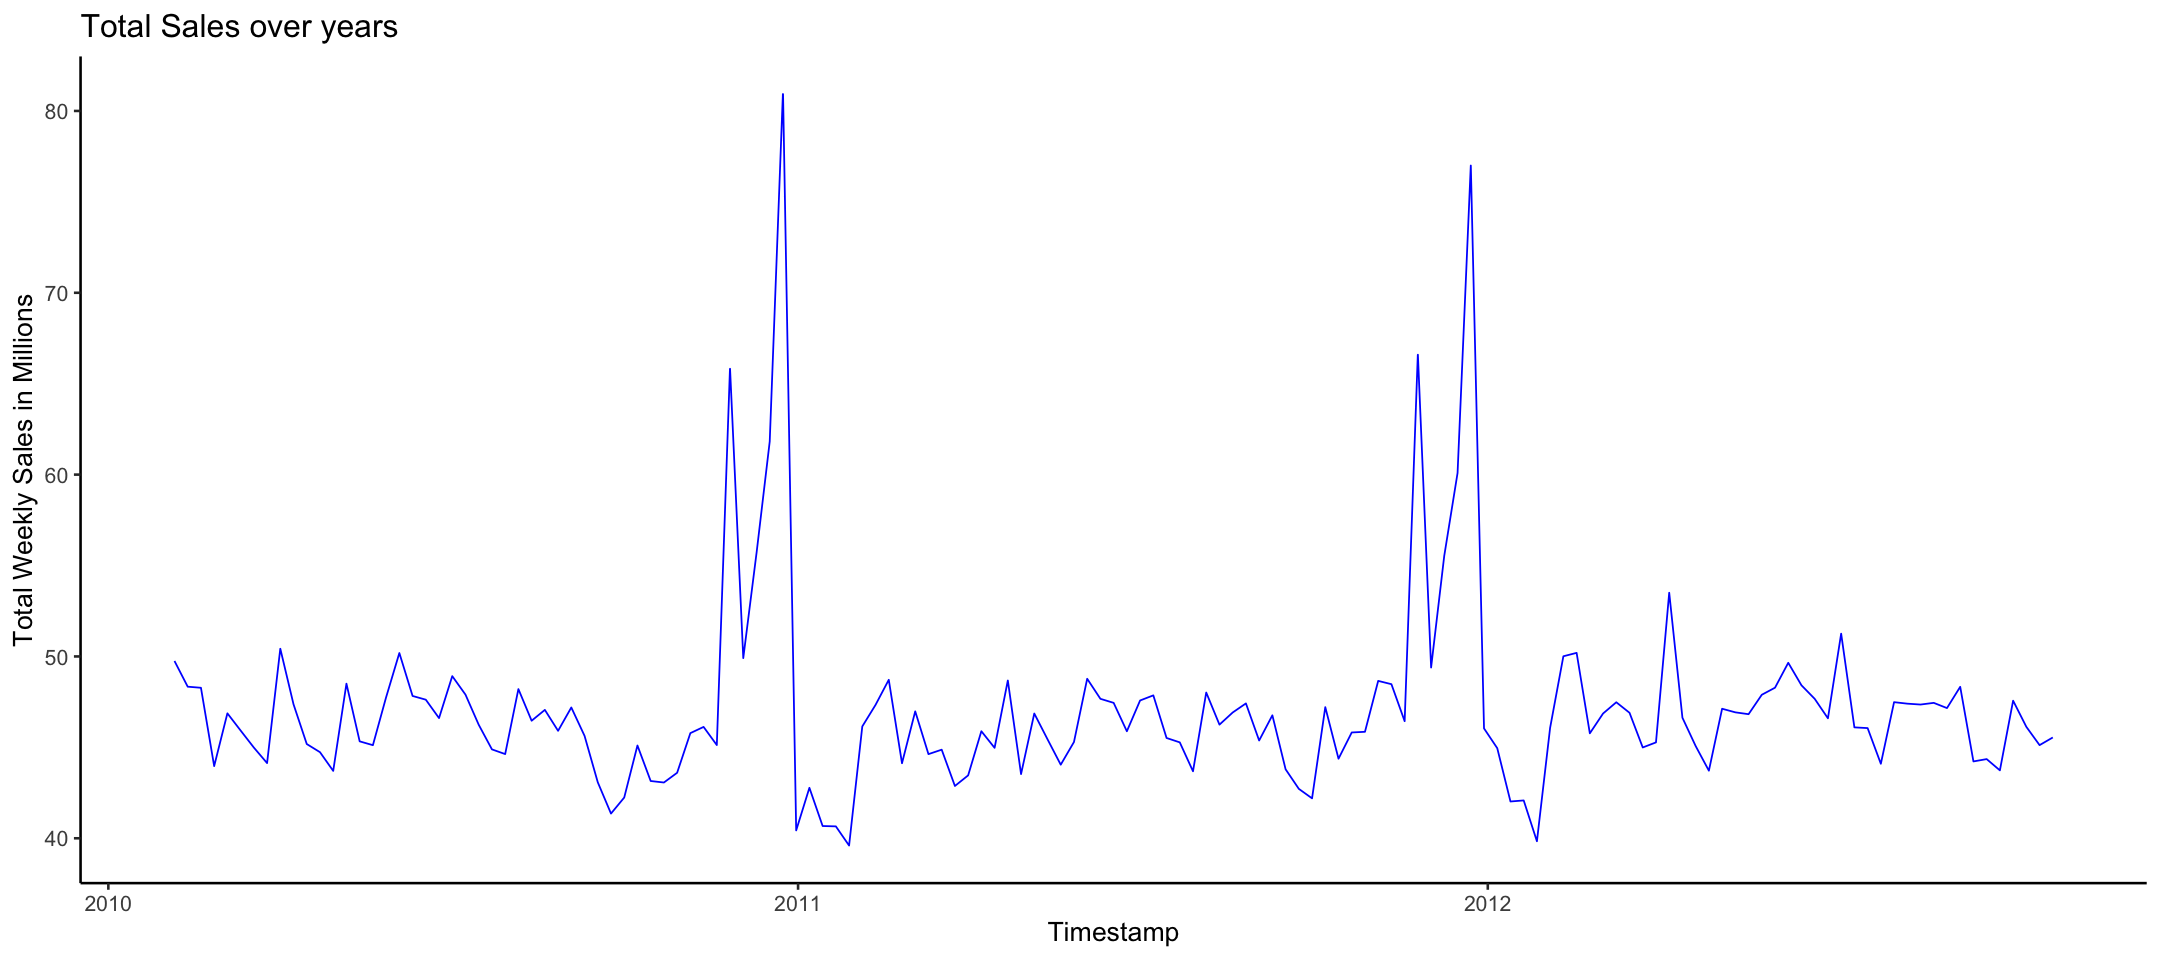

In [6]:
# Plot for total sales through time:

options(repr.plot.width=18, repr.plot.height=8)
avg_data %>%
    ggplot(aes(Date, Sales/1000000, group = 1)) +
    geom_line(colour='blue', alpha=1) +
    theme_classic(base_size = 16) +
    xlab("Timestamp") +
    ylab("Total Weekly Sales in Millions") + 
    ggtitle("Total Sales over years")

- Trend appears to be linear and stationary.


- Seasonality appears to be non-linear owing to holiday seasonal jumps around the end of each year, which is an expected behaivour.


- Pattern appears to be constant and repetitive with each year experiencing a seasonal jump during the end of the year, but no evident cyclic pattern can be observed here.

## 4.1. Classical decomposition

The classical decomposition method originated in the 1920s. It is a relatively simple procedure, and forms the starting point for most other methods of time series decomposition. There are two forms of classical decomposition: an additive decomposition and a multiplicative decomposition.  In classical decomposition, we assume that the seasonal component is constant from year to year.

In [7]:
# prepare time series data with weekly frequency:

df_ts_weekly = ts(avg_data$Sales, 
               freq=365.25/7, 
               start=decimal_date(ymd("2010-02-05")))

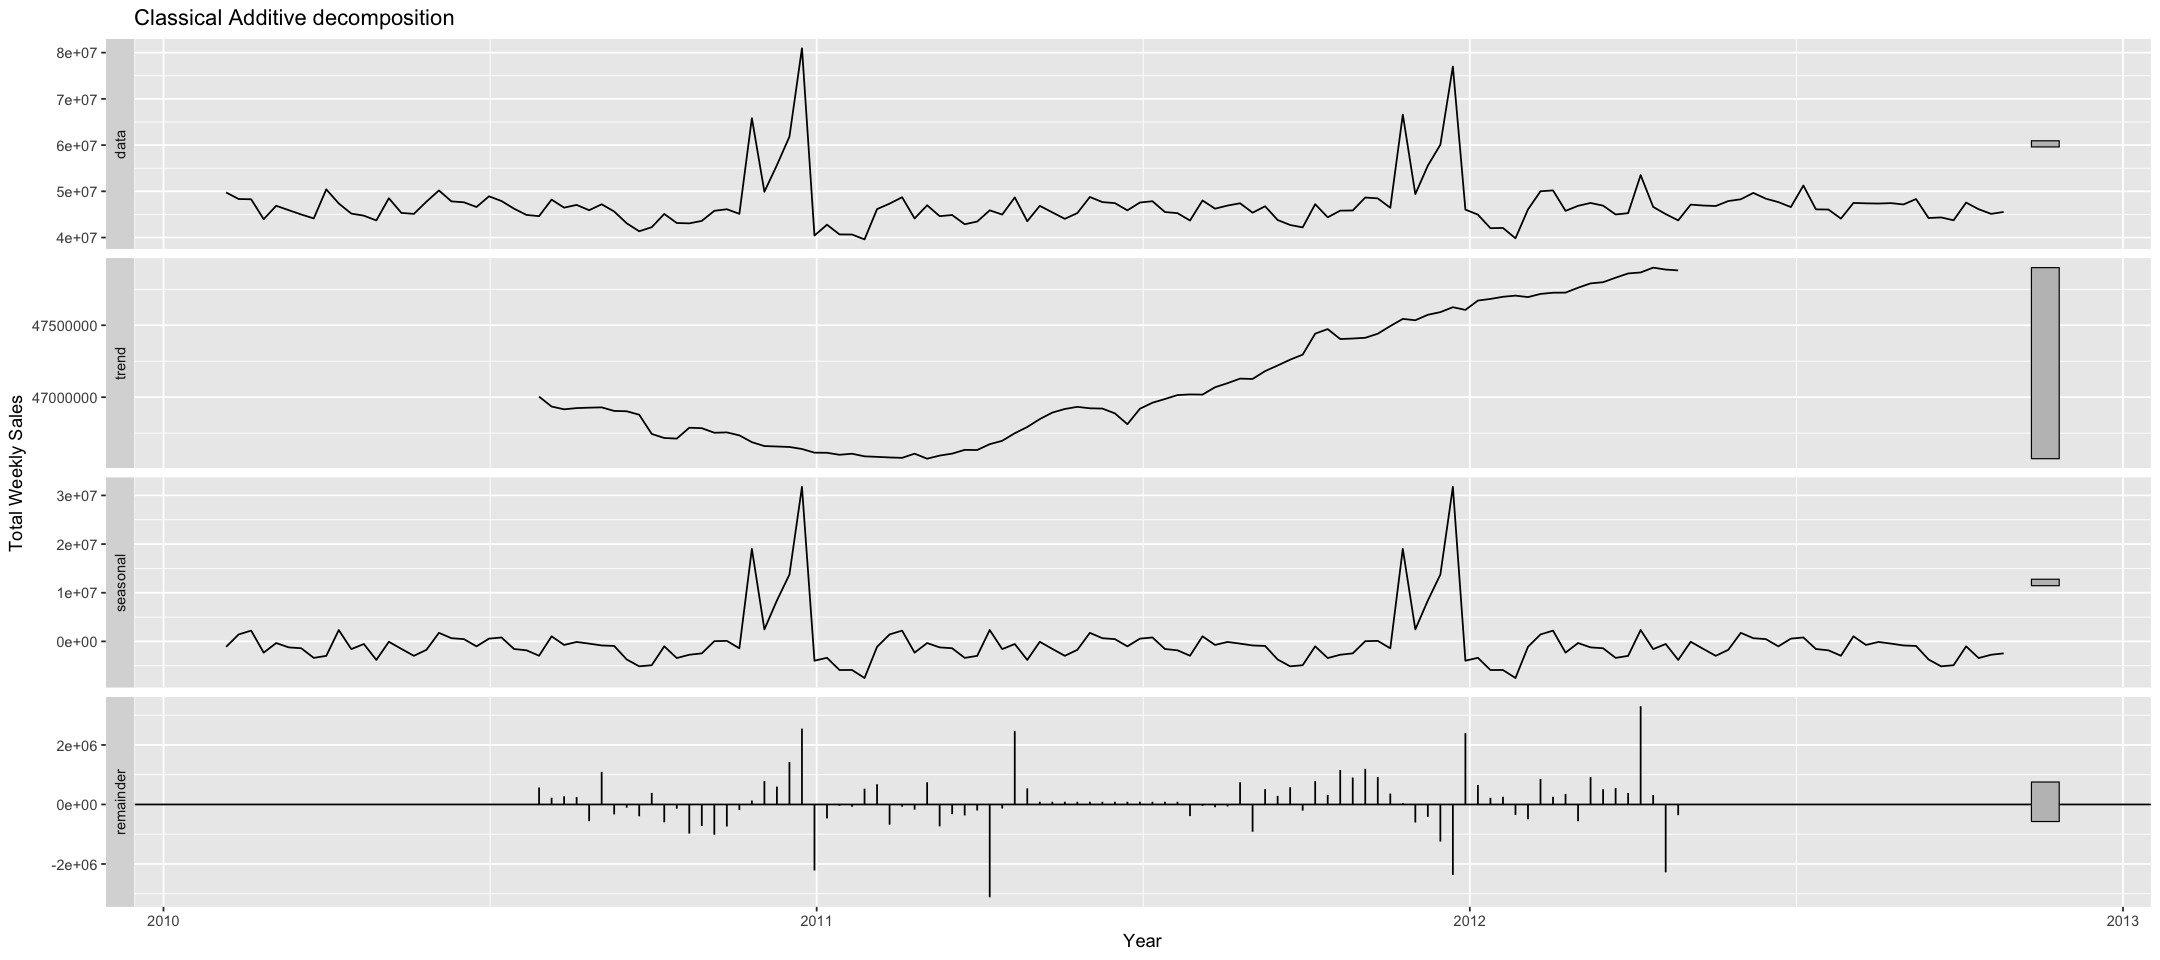

In [8]:
# Perform additive decomposition
additive_decomp <- decompose(df_ts_weekly, type = "additive")

# Perform multiplicative decomposition
multiplicative_decomp <- decompose(df_ts_weekly, type = "multiplicative")

# Plot the original time series, trend, seasonal, and random components for additive decomposition
autoplot(additive_decomp) + 
    ylab("Total Weekly Sales") +
    xlab("Year") +
    ggtitle("Classical Additive decomposition")

# Plot the original time series, trend, seasonal, and random components for multiplicative decomposition
# autoplot(multiplicative_decomp) + 
#     ylab("Total Weekly Sales") +
#     xlab("Year") +
#     ggtitle("Classical multiplicative decomposition")

- Right on the target goo trend analysis!

CONS:

While classical decomposition is still widely used, it is not recommended, as there are now several much better methods. Some of the problems with classical decomposition are summarised below.

- Classical decomposition methods assume that the seasonal component repeats from year to year. For many series, this is a reasonable assumption, but for some longer series it is not. The classical decomposition methods are unable to capture these seasonal changes over time.

## 4.2. X11 decomposition

This method is based on classical decomposition, but includes many extra steps and features in order to overcome the drawbacks of classical decomposition that were discussed in the previous section. In particular, trend-cycle estimates are available for all observations including the end points, and the seasonal component is allowed to vary slowly over time. 

## 4.3. Seasonal Extraction in ARIMA Time Series decomposition (SEATS)

This procedure was developed at the Bank of Spain, and is now widely used by government agencies around the world. The procedure works only with quarterly and monthly data. So seasonality of other kinds, such as daily data, or hourly data, or weekly data, require an alternative approach.

## 4.4. Seasonal and Trend decomposition using Loess decomposition (STL)

STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while Loess is a method for estimating nonlinear relationships. The STL method was developed by R. B. Cleveland, Cleveland, McRae, & Terpenning (1990), University of Michigan Ann Arbor



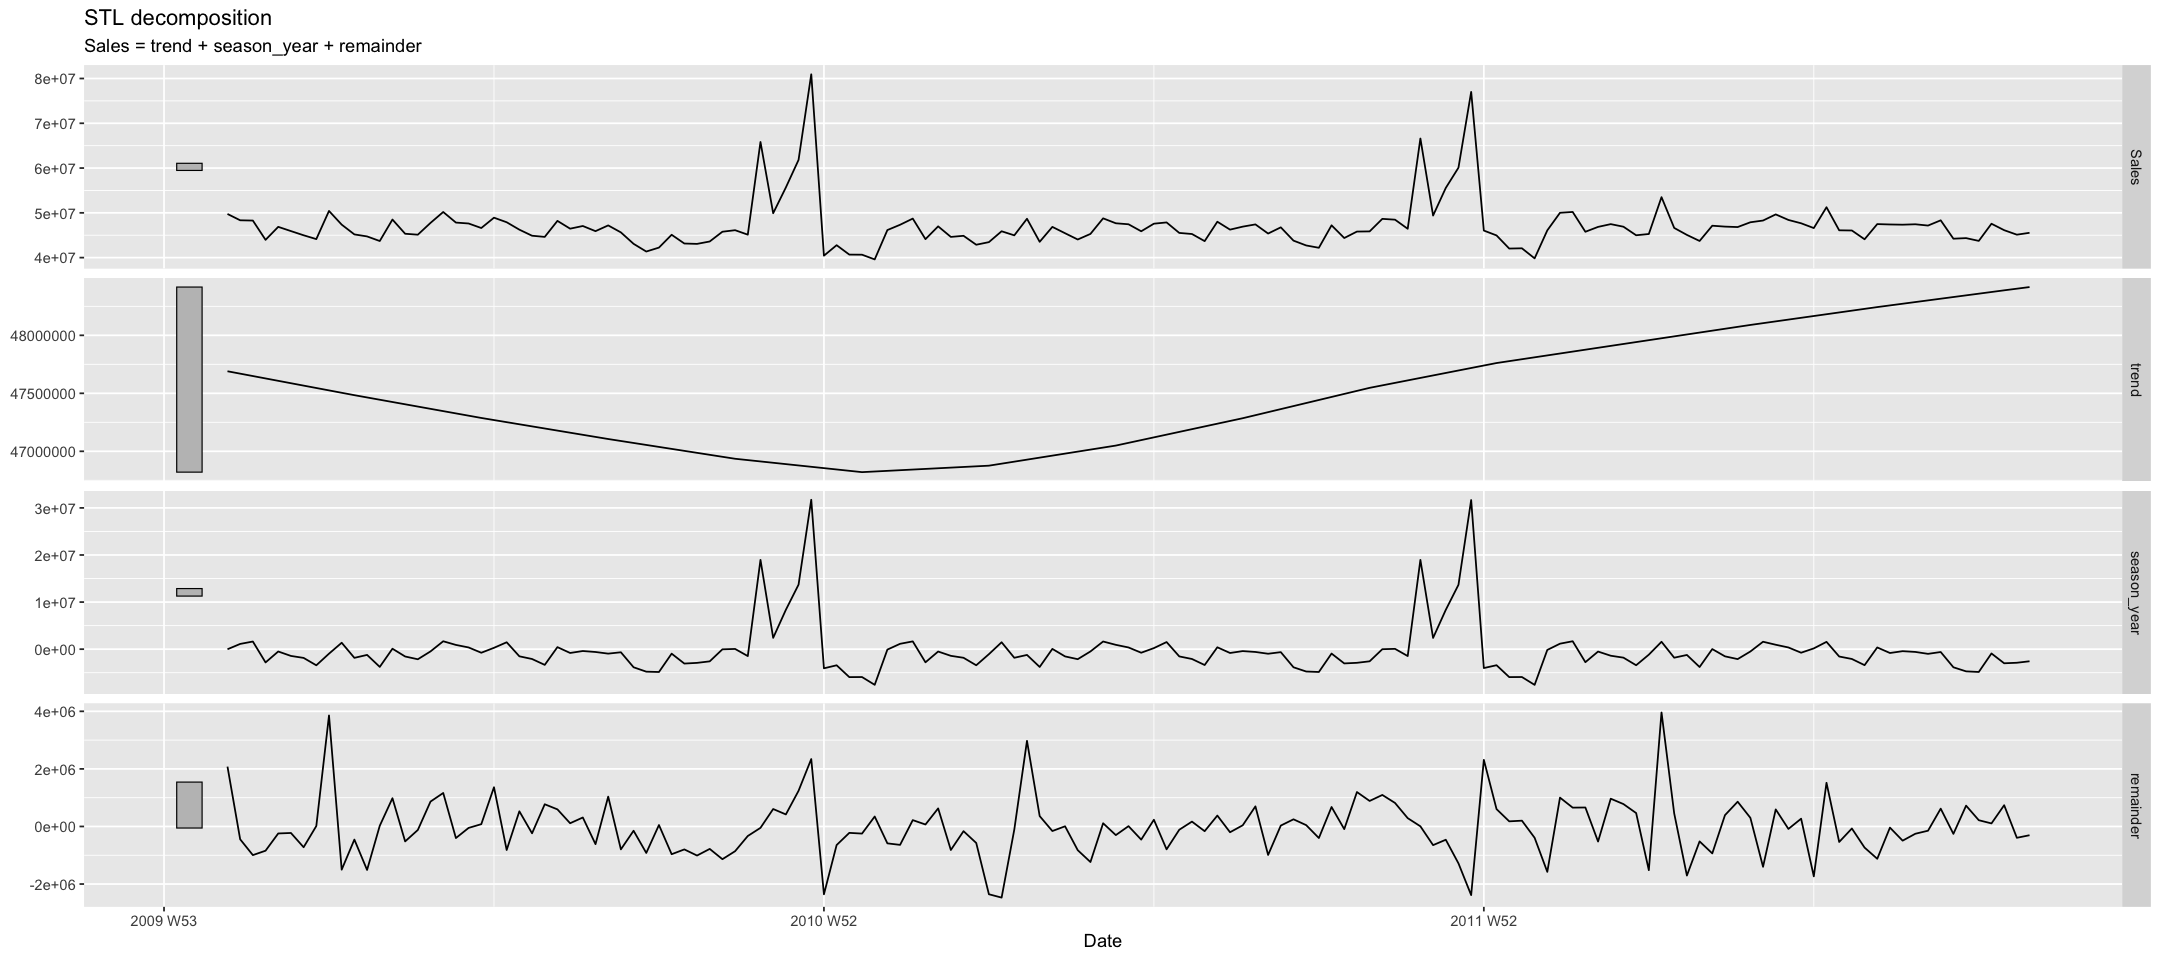

In [9]:
df_ts %>%
    model(STL(Sales)) %>% 
    components() %>% 
    autoplot()

STL decomposition where the trend-cycle is more flexible (a bit over-smoothed the drop in the data), the seasonal component does not change over time, and the robust option has been used. 

Great estimates! Matching with the original analyis.

Not a good estimate.

## 4.5. Classical vs STL decomposition 

- STL (Seasonal and Trend decomposition using Loess) is considered better than classical decomposition in some cases because it can handle nonlinear trends and non-constant variance.

- In classical decomposition, the trend component is assumed to be linear, and the seasonal component is assumed to be constant over time. This assumption may not hold true for many real-world time series data that have non-linear trends or time-varying seasonal patterns.


- On the other hand, STL uses a locally weighted regression technique (Loess) to estimate the trend and seasonal components, allowing for non-linear trends and time-varying seasonal patterns. Additionally, STL also includes a remainder component that captures any remaining variations in the data after removing the trend and seasonal components, which can be useful for detecting outliers and other anomalies.

## 4.6. Forecasting using STL decomposition

In [13]:
# STL model:
stl <- decomposition_model(
STL(Sales),
ETS(season_adjust ~ season("N")))


Warning message:
“Removed 52 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 52 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 52 rows containing non-finite values (`stat_bin()`).”


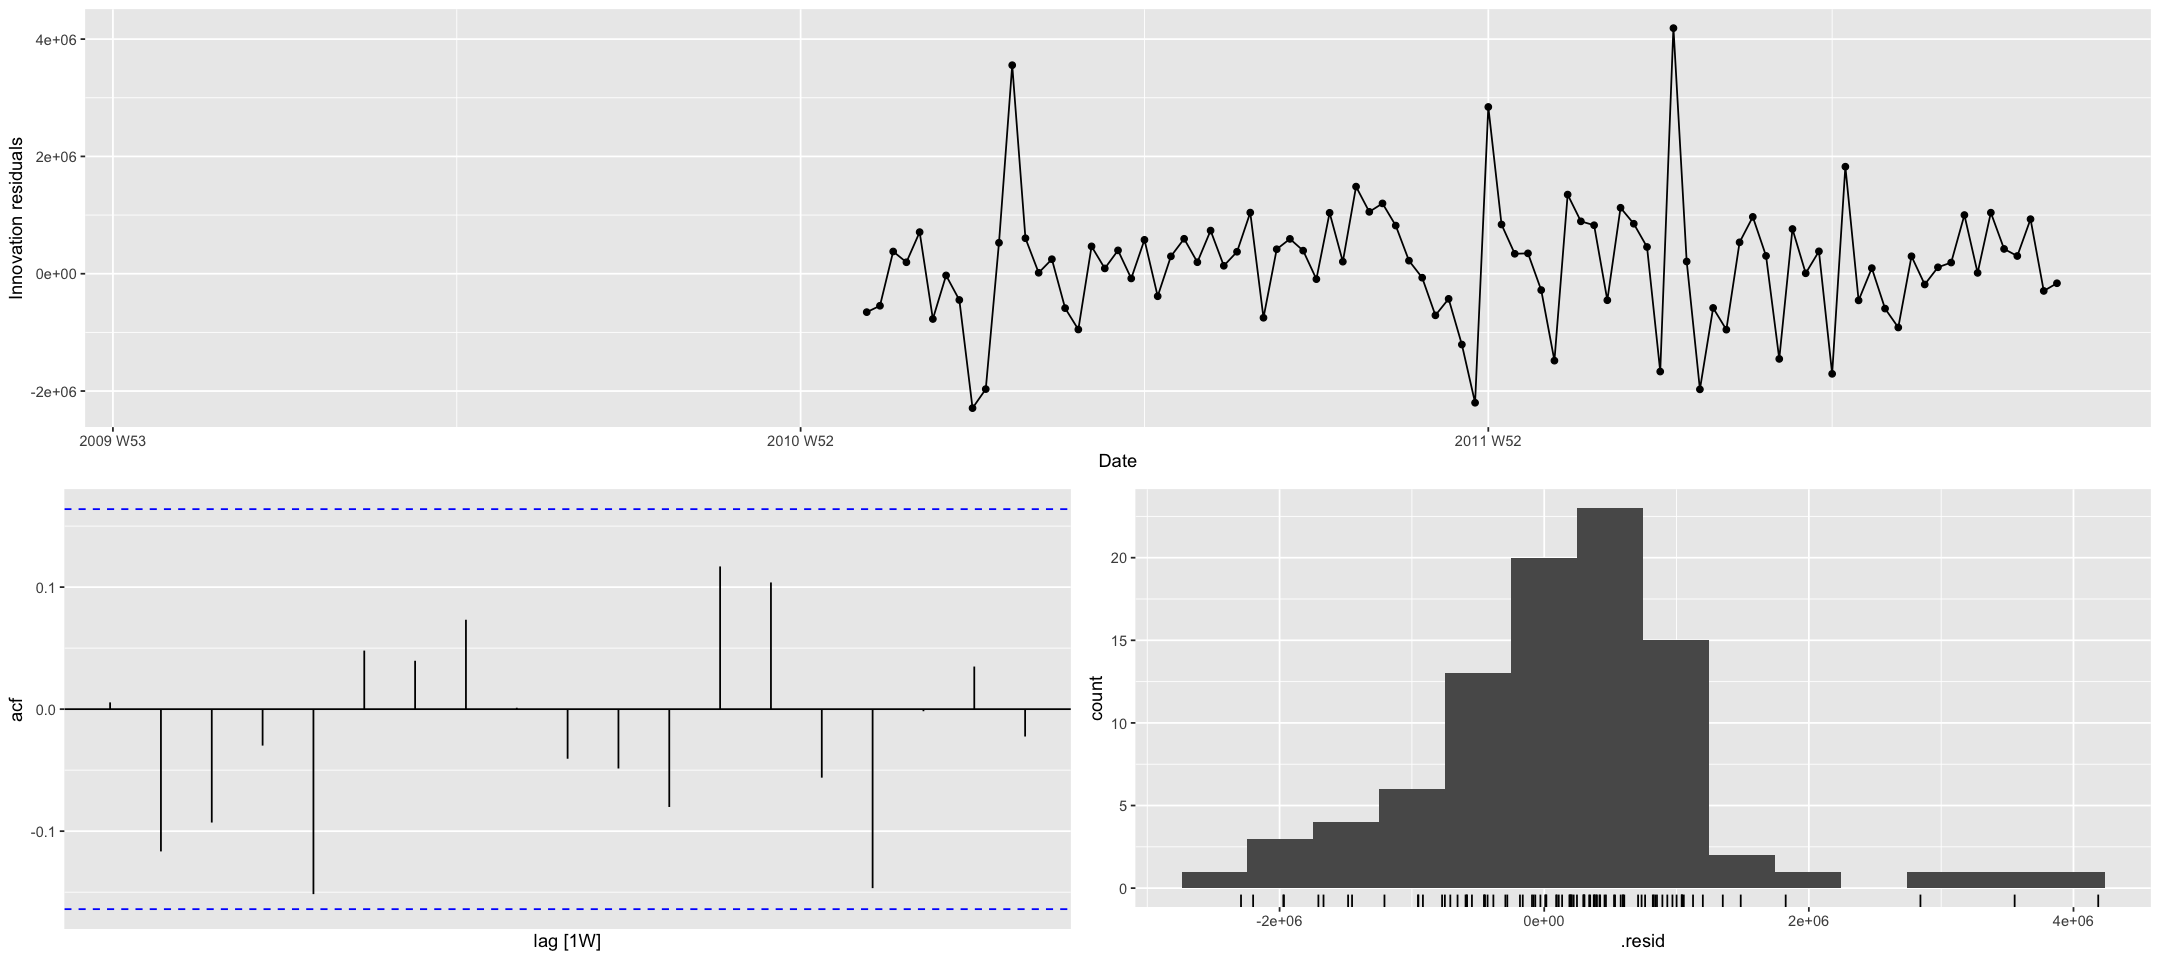

In [14]:
# Train model:

stl_model = model(df_ts, 
                  stl_ets_all = stl)


# Check residual:

gg_tsresiduals(stl_model)

In [15]:
# Forecasting:

fc_data = forecast(stl_model, h=10)

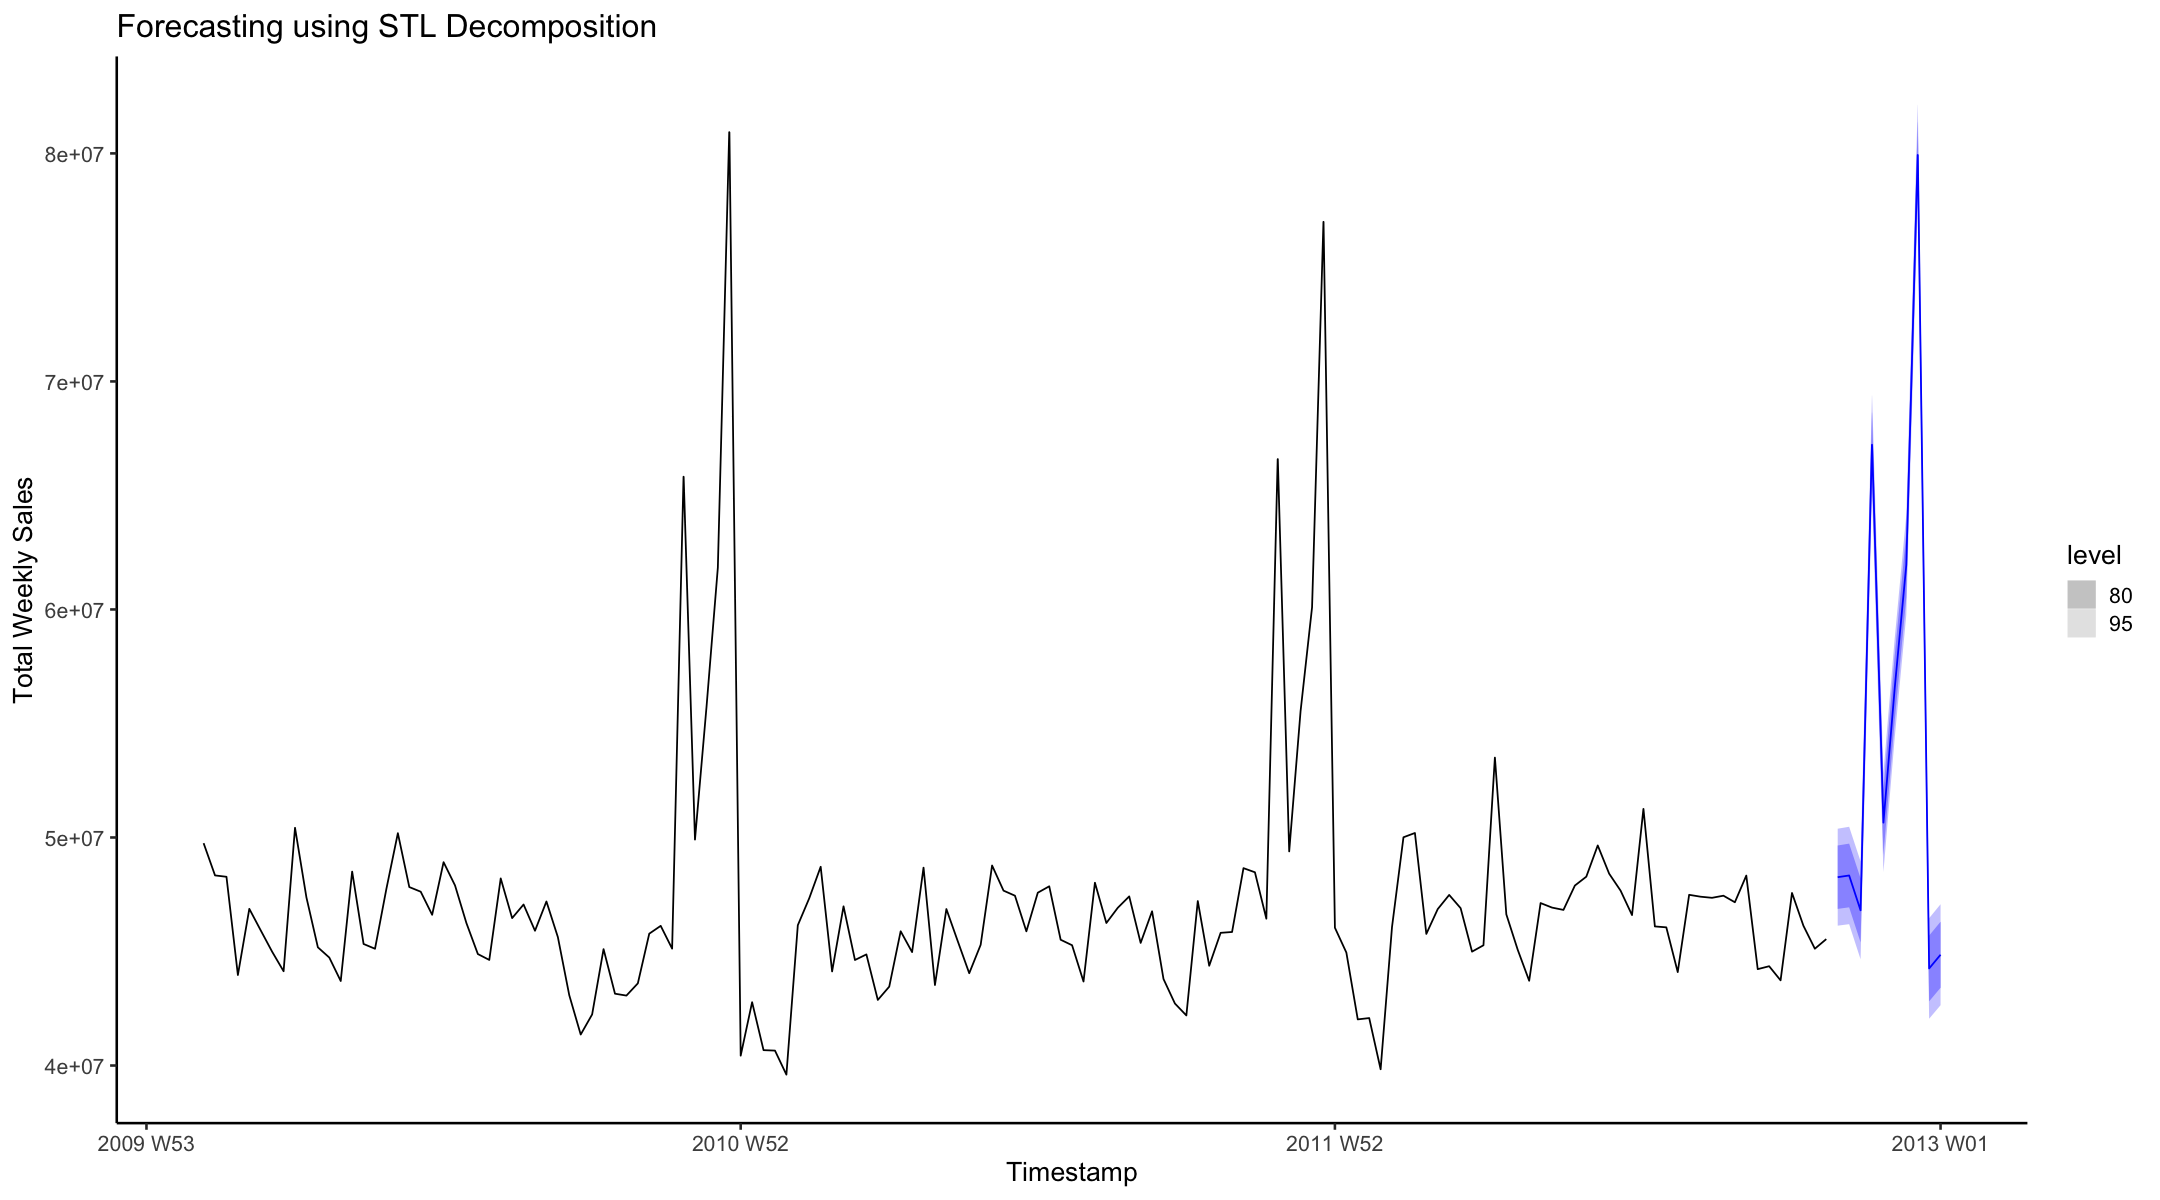

In [22]:
# Forecast Plot:

options(repr.plot.width=18, repr.plot.height=10)

fc_data %>% 
    autoplot(df_ts) +
        xlab("Timestamp") + 
        ylab("Total Weekly Sales") + 
        ggtitle("Forecasting using STL Decomposition") + 
        theme_classic(base_size = 16)

---
---